# 10-9. 프로젝트: CAM을 만들고 평가해 보자


In [4]:
# 라이브러리 불러오기

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

In [7]:
# 데이터셋 로드하기

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split =['train', 'test'],
    shuffle_files= True,
    with_info = True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


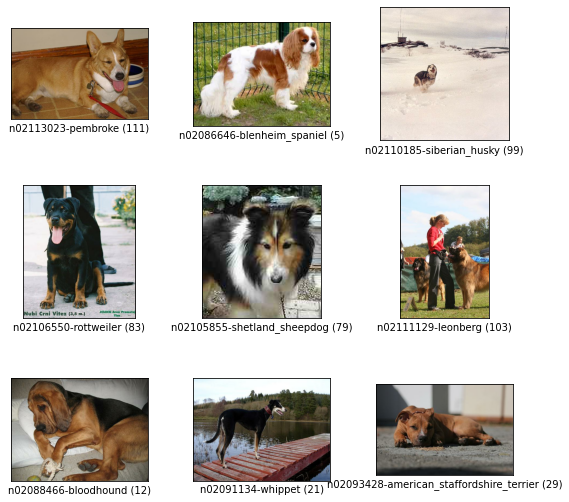

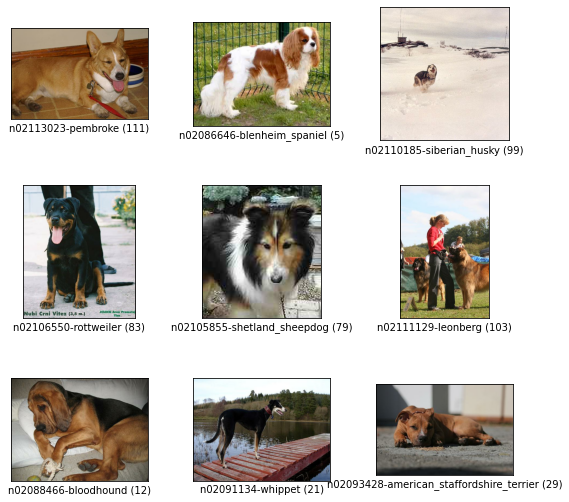

In [8]:
# 학습용 데이터셋 확인
tfds.show_examples(ds_train, ds_info)

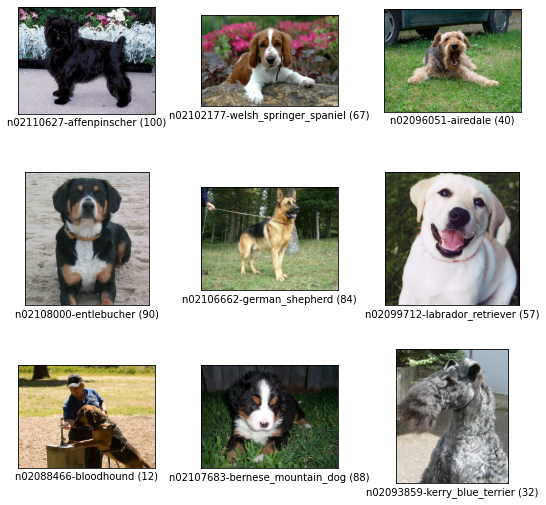

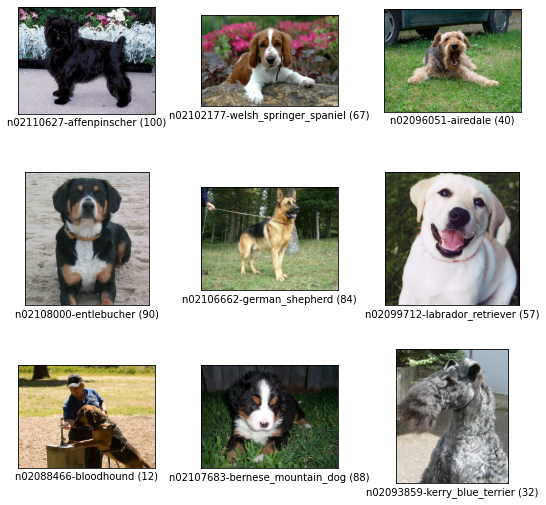

In [9]:
# 평가용 데이터셋 확인
tfds.show_examples(ds_test, ds_info)

# 모델 만들기


In [10]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top =False, # Imagenet 분류기 fully connected layer 제거
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg', # GAP를 적용
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs= preds)


94781440/94765736 [==============================] - 0s 0us/step


In [11]:
# CAM모델 확인
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [12]:
def normalize_and_resize_img(input):
    # Normalizes images: 'uint8' -> 'float32'
    image = tf.image.resize(input['image'],[224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [13]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다.
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


# 모델 컴파일 및 학습

In [27]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy']
)



In [28]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples / 16 ),
    validation_steps=int(ds_info.splits['test'].num_examples / 16),
    epochs=5,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
750/750 [==============================] - 169s 209ms/step - loss: 2.2054 - accuracy: 0.4467 - val_loss: 3.0474 - val_accuracy: 0.2689
Epoch 2/5
750/750 [==============================] - 155s 207ms/step - loss: 0.7117 - accuracy: 0.8006 - val_loss: 1.3828 - val_accuracy: 0.6104
Epoch 3/5
750/750 [==============================] - 155s 206ms/step - loss: 0.2356 - accuracy: 0.9498 - val_loss: 0.9900 - val_accuracy: 0.7129
Epoch 4/5
750/750 [==============================] - 155s 207ms/step - loss: 0.1173 - accuracy: 0.9842 - val_loss: 0.9507 - val_accuracy: 0.7356
Epoch 5/5
750/750 [==============================] - 155s 206ms/step - loss: 0.0369 - accuracy: 0.9978 - val_loss: 0.9486 - val_accuracy: 0.7377


In [29]:
# 학습된 가중치를 저장하기
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model3.h5'
cam_model.save(cam_model_path)


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [30]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

100


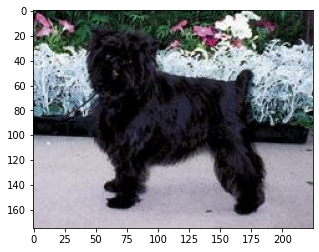

In [37]:
# CAM 생성하기

item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

In [32]:
# 학습된 모델 불러오기

import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model3.h5'
cam_model = tf.keras.models.load_model(cam_model_path)
print('슝=3')

슝=3


In [33]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image


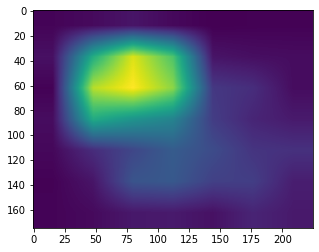

In [38]:
# CAM 이미지 실행

cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [35]:
# CAM 이미지를 원본 이미지와 합쳐 보기
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image


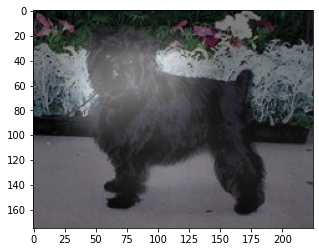

In [39]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# Grad-CAM
**Grad-CAM을 이용해서 CAM을 얻기**


108


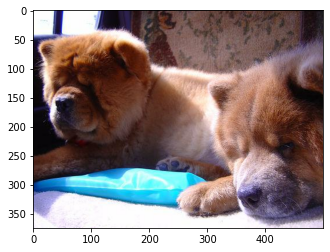

In [40]:
#새로운 이미지 뽑기
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()


In [41]:
# grad-cam
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('슝=3')

슝=3


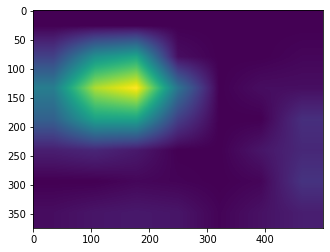

In [42]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

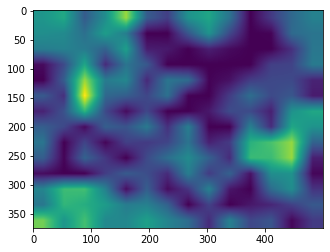

In [43]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

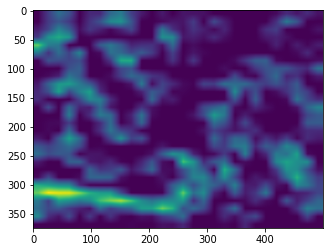

In [44]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

# 바운딩 박스
CAM에서 물체의 위치를 찾는 detection을 해보기


12


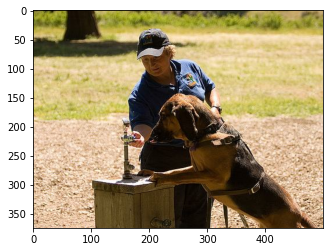

In [45]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

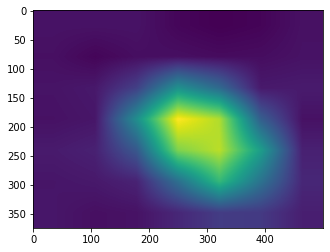

In [46]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [47]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('슝=3')

슝=3


In [48]:
rect = get_bbox(cam_image)
rect

array([[109, 373],
       [109,  87],
       [498,  87],
       [498, 373]])

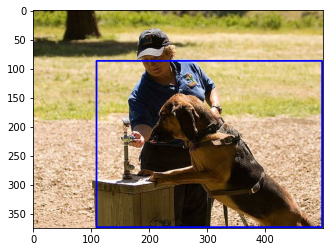

In [49]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

# Intersection Over Union


In [50]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox
print(image.shape[1])
print('슝=3')

500
슝=3


In [55]:
# minmax bbox형태로 치환
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.232, 0.218, 0.9946666666666667, 0.996]

In [56]:
# ground truth bbox확인
item['objects']['bbox']

array([[0.368    , 0.352    , 0.9946667, 0.986    ]], dtype=float32)

In [57]:
# IOU 계산
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('슝=3')

슝=3


In [58]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6695938910383507

# grad-cam 적용하여 IOU구하기

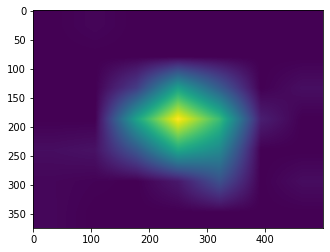

In [59]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

In [60]:
rect = get_bbox(grad_cam_image)
rect

array([[ 79, 255],
       [163,  27],
       [442, 129],
       [358, 357]])

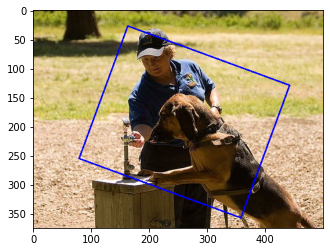

In [61]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

In [62]:
# minmax bbox형태로 치환
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.072, 0.158, 0.952, 0.884]

In [63]:
# ground truth bbox확인
item['objects']['bbox']

array([[0.368    , 0.352    , 0.9946667, 0.986    ]], dtype=float32)

In [64]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.42824061479550013

# 회고
***
Class Activation Map 을 얻기 위한 cam과 grad-cam 모델을 구현하여 IOU 스코어까지 비교해 보았다.  
cam모델로 IOU는 0.67정도나왔고 grad-cam모델은 0.43정도 나왔다.  
결과적으론 기본 cam 모델이 더 성능이 좋았다.  
grad-cam은 아무래도 cam을 더 범용적으로 사용하기 위한 모델로 만들어져서 성능면에서는 떨어진다고 생각한다.  